In [13]:
from datetime import datetime
from typing import List

import textwrap
import pandas as pd
from graphviz import Digraph
from IPython.display import display
import pyclip

from read_telega_dump import telega_dump_parse_essential
from data_classes import TelegaMessage, TelegaMessageIndex

In [14]:
dump_path = r"/Users/dklmn/Documents/data/telega/result.json"
msgs = telega_dump_parse_essential(dump_path=dump_path)
mi = TelegaMessageIndex()
msgs_list = []
for msg in msgs:
    mi.add_item(msg)
    msgs_list.append(msg)
# note: for data, taken from "export chat history", we do not have number of reactions 
msgs_list[0]


6861it [00:00, 15854.82it/s]


183554:2024-08-01T00:09:31Z; О, новые цены на рейсы Анталия - Стамбул подвезли

In [4]:
topic_msgs = mi.get_messages_tree(189845)
topic_msgs

[189845:2024-08-29T10:18:23Z; Ребят, кто кото-владельцы, а вы чем своих питомцев кормите?
 Мы покупали Farmina, сербского развеса, но на него ценник переписали - за месяц с 1100 до 1900 за полтора кг.
 Наш 2 пачки в месяц сжирает плюс паштетики еще, я прикинул - я за август на питание себя потратил наверно меньше,
 189875:2024-08-29T11:10:05Z; Сухой роял канин на развес по ~ 300 лир за кг,
 189916:2024-08-29T14:01:13Z; Фарминой кормим, кошка съедает 1,5 кг за 1,5 месяца. А что у вас за кот ( я как то удивлена 3 кг за 1 месяц…),
 189917:2024-08-29T14:01:46Z; Прожорливый,
 189918:2024-08-29T14:03:26Z; И какая именно фармина?,
 189919:2024-08-29T14:04:49Z; Может просто порода с весом около 6 кг и выше, тогда понятно,
 189920:2024-08-29T14:07:38Z; Кошки в принципе едят более адекватно. Все коты что у меня были не знают меры, и жрут как в последний раз,
 189922:2024-08-29T14:08:54Z; А коты были бывшие бездомными?,
 189923:2024-08-29T14:10:17Z; У меня обратная статистика 🙄,
 189924:2024-08-2

In [7]:
"""To visualize chain of messages as topic tree.
Note: for macOS need to do: 
brew install graphviz
After installation, verify that the `dot` command is available in your PATH. You can check this by running the following command in your terminal:

```bash
dot -V
```
"""
def visualize_topic_tree(messages: List[TelegaMessage]):
    # Create a directed graph
    dot = Digraph()
    # Add nodes
    for message in messages:
        dot.node(str(message.msg_id), f"{message.user_name}\n{message.msg_date}\n{textwrap.fill(message.msg_text, width=30) or ''}")

        if message.reply_to_msg_id is not None:
            # Add an edge for the parent-child relationship
            dot.edge(str(message.reply_to_msg_id), str(message.msg_id))

    return dot

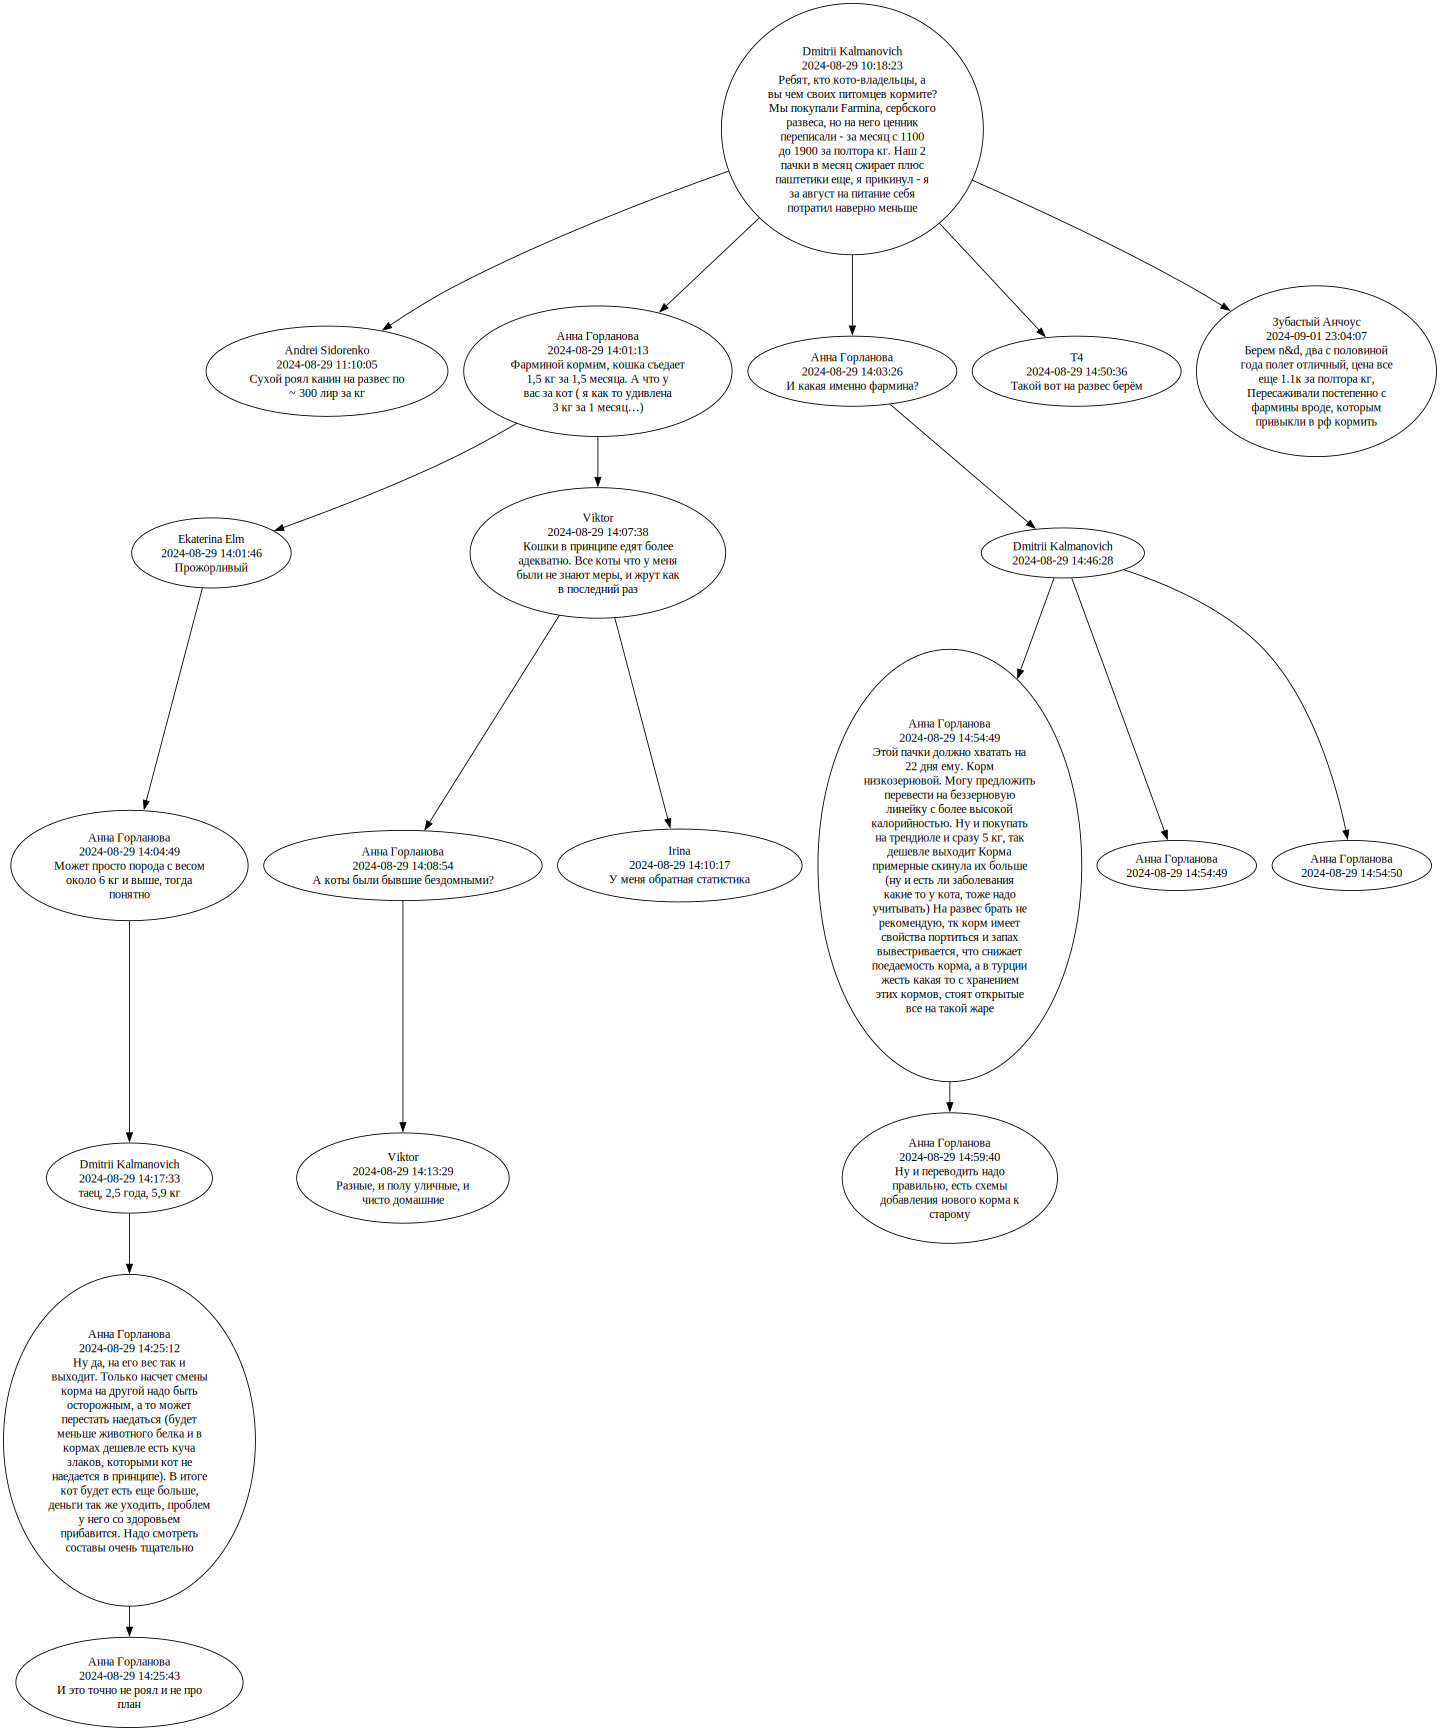

In [8]:
# Visualize the messages
dot = visualize_topic_tree(topic_msgs)
dot.attr(size='20, 40')  # Width and height (in inches)
dot.attr(rankdir='TB')  # Top to bottom layout
dot.render('messages_tree', format='png', cleanup=True)  # save as PNG
display(dot)  # to display in Jupyter notebook


In [29]:
import json
# Custom serialization function for datetime objects
def date_to_json_serialize(obj):
    if isinstance(obj, datetime):
        return obj.isoformat()  # or obj.strftime('%Y-%m-%d %H:%M:%S')
    raise TypeError("Type not serializable")

subset = msgs_list[-100:] # last n messages
dss = [msg.model_dump() for msg in subset]
json_string = json.dumps(dss, default=date_to_json_serialize, ensure_ascii=False, indent=4)
print(f'len str ={len(json_string)}')
pyclip.copy(json_string) # copy to clipboard for feeding to LLM

len str =30356


In [30]:

dd = (msg.model_dump() for msg in msgs_list)
df = pd.DataFrame.from_dict(dd)

In [31]:
df.shape

(102050, 6)

In [10]:
df.dtypes

msg_id                      int64
msg_date           datetime64[ns]
user_name                  object
user_id                    object
reply_to_msg_id           float64
msg_text                   object
dtype: object

### Overall statistics

In [11]:
df['dummi'] = 1 # there should be less ugly way to get different aggegations without grouping
agg_df = df.groupby('dummi').aggregate({'msg_id':'count','msg_date':['min','max'], 'user_id': 'nunique'}).reset_index()
msgs_cnt = agg_df[( 'msg_id', 'count')][0]
min_date = agg_df[('msg_date', 'min')][0]
max_date = agg_df[('msg_date', 'max')][0]
number_of_days = (max_date-min_date).days
unique_users =  agg_df[('user_id', 'nunique')][0]
del df['dummi'] 
cols = ["Metric name", "Value"]
dt_format = "%Y-%m-%d"
d_report = [
    {cols[0]: "Number or messages", cols[1]: msgs_cnt},
    {cols[0]: "Date interval", cols[1]: f'from {min_date.strftime(dt_format)} to {max_date.strftime(dt_format)}' },
    {cols[0]: "Users count", cols[1]: unique_users },
    {cols[0]: "Avg messages per day", cols[1]: round(msgs_cnt/number_of_days , 1) },
    ]
pd.DataFrame.from_dict(d_report)






,Metric name,Value
0,Number or messages,102050
1,Date interval,from 2023-01-01 to 2024-08-25
2,Users count,791
3,Avg messages per day,169.5


### assign date range if you want to restict dataset to some particular period for futher analysis, or just ignore the cell below 

In [31]:

# tz = timezone('Europe/Istanbul')
dt_range = (pd.Timestamp(year=2024, month=8, day=23), pd.Timestamp(datetime.now()))   # , tz=tm_zn        
number_of_days = (dt_range[1]-dt_range[0]).days
print(f'{number_of_days=}')
df = df[df.msg_date.between(*dt_range)]
df.shape


number_of_days=8


(307, 7)

In [11]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()


ObjectApiResponse({'name': 'b5426ee70422', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'PFgTgTLvSU63_psQqF3g2w', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})


Step 4: Create Mappings and Index

    Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

    Each document is a collection of fields, which each have their own data type.

    We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored



In [2]:
import config as cfg

index_name = "telegram-messages"
index_settings_messages = cfg.read_index_settings(index_name)
print(index_settings_messages)




NameError: name 'read_index_settings' is not defined

In [4]:
index_settings_topics = cfg.topics_index_settings()

In [106]:
index_name = "telegram-messages"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'telegram-messages'})

In [10]:
subset = [x for x in msgs if x['msg_date']> datetime(2024,8, 1)]

In [109]:
from  tqdm import tqdm
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o-mini")
for doc in tqdm(subset):
    msg_text = doc["msg_text"]
    # Transforming the title into an embedding using the model
    # doc["msg_text_vector"] = model_st.encode(msg_text).tolist()
    doc['len'] = len(msg_text)
    doc["num_tokens"] = len(encoding.encode(msg_text))
    es_client.index(index=index_name, document=doc)


100%|██████████| 5246/5246 [00:26<00:00, 196.42it/s]


In [124]:
es_client.count(index=index_name)

ObjectApiResponse({'count': 5246, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

Test end users query

In [101]:
search_term = "криптообменники"
knn_query = {
    "field": "msg_text_vector",
    "query_vector": model_st.encode(search_term),
    "k": 5,
    "num_candidates": 10000, 
}

In [145]:
search_term = "сплав по реке"
text_query = {
    "query": {
        "match": {
            "msg_text": search_term
        }
    },
    "size": 20  # Adjust this number to include more documents
}

In [146]:
# res = es_client.search(index=index_name, knn=knn_query, source=["msg_text", "msg_date"])
res = es_client.search(index=index_name, body=text_query, source=["msg_text", "msg_date"])
res["hits"] #["hits"]

/var/folders/_s/0tpy0fpj29nd_8qm0ldhz6nw0000gn/T/ipykernel_52819/4052011558.py:2: DeprecationWarning: Received 'source' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  res = es_client.search(index=index_name, body=text_query, source=["msg_text", "msg_date"])


{'total': {'value': 3, 'relation': 'eq'},
 'max_score': 7.9194794,
 'hits': [{'_index': 'telegram-messages',
   '_id': 'J_1XmpEBhq3eaWQ52YBG',
   '_score': 7.9194794,
   '_source': {'msg_date': '2024-08-09T12:56:43',
    'msg_text': 'Проблемы есть, но в сравнении с РФ незначительные, потому что их можно тут сплавить бигбиту или чему-то такому'}},
  {'_index': 'telegram-messages',
   '_id': '2v1XmpEBhq3eaWQ5yHy9',
   '_score': 5.9018955,
   '_source': {'msg_date': '2024-08-06T13:19:16',
    'msg_text': 'А кто-то ходил на Тунектепе недавно, ато вижу рекламу в канале, что был поход. Почему-то думал, что там закрыто после авариию Через русло реки значит тоже можно снова зайти?'}},
  {'_index': 'telegram-messages',
   '_id': '1v1XmpEBhq3eaWQ5uXob',
   '_score': 1.777031,
   '_source': {'msg_date': '2024-08-03T16:56:30',
    'msg_text': 'В том году ездили осенью. Можно договориться на месте, можно предварительно написать в ватсап. Они часов с 8-9 начинают работать, лучше к этому времени прие